Sequential Monte Carlo is a general class of methods designed to sample sequentially from a sequence of target densities. State-space models is an example of a class of models that naturally have a sequence of target densities, if we're interested in latent-state estimation.

For me, Sequential Monte Carlo is the epitome of "the math is confusing but the idea is simple", so this post will take a stab at distilling the idea with math and code. 


## Overall Problem 

I find that the combination of math and code makes algorithms much easier to understand, so here's the math. I'll mainly follow the notation from [this](https://www.stats.ox.ac.uk/~doucet/doucet_defreitas_gordon_smcbookintro.pdf) paper, but will only write down the neccessities. 

The latent states, $X_t$ are modelled as a Markov process with initial state $p(x_0)$ and transition equation $p(x_t \mid x_{t-1})$. The observed data, $Y_t$, is assumed to be conditionally independent given the hidden state at time $t$, $X_t$, and has density $p(Y_t \mid X_t)$. The model is completely specified by the following: 

$$
\begin{aligned}
X_0 \sim p(x_0) & \qquad \qquad \text{Initial state} \\
p(X_t \mid X_{t-1}) &  \qquad \qquad \text{Transition density} \\
p(Y_t \mid X_t) & \qquad \qquad \text{Marginal of $Y_t \mid X_t$?}
\end{aligned}
$$

The aim is to estimate the posterior distribution of the latent states, $p(X_t \mid Y_t)$, which we use the bootstrap particle filter for. 


The bones of these notes come from [here](https://ib.berkeley.edu/labs/slatkin/eriq/classes/guest_lect/mc_lecture_notes.pdf), and I've adapted it a bit to help myself understand the concepts. 

## Setting the stage

We're interested in finding the expecation of some distribution, $f(x)$. This seems pretty general, but many useful quantities can be expressed as expectations, for example: 

- Probabilities are expectations of indicator functions:

$$ P(X = A) = E(I_A(X) $$

- Definite integrals between $[a, b]$ can be expressed as expectations over Uniform random variables. Say we want to integrate a function, $q(x)$ between $[a, b]$. Starting with the expected value of $X \sim U(a, b)$:

$$ E(q(X_u)) = \int_b^a q(x) \frac{1}{b-a} dx $$

$$ \int_b^a q(x) dx = (b-a)E(q(X_u)) $$


## Monte Carlo Estimates

The general idea here is to generate samples from a distribution that is easy to sample from, like $X \sim U(0,1)$. Then transform these samples using out function of interest, $q(x)$, and find the average of these values. 

Immediately, a problem arises which is that the distribution we sample from needs to be close-ish to the function of interest, or the method will be inefficient. This is where importance sampling comes in.


## Importance Sampling

The problem we are trying to solve with importance sampling is that during our Monte Carlo estimation scheme, the choice of sample distribution can throw off our estimates. IS deals with this problem by re-weighting the proposed samples to be closer in density to the function of interest. It does this re-weighting by multiplying the integrand "by 1". For example, we are interested in computing the integral of $g(x)$ in a region, $A$. Let $X \sim h(x)$ be a density where $\int_{x \in A} h(x) dx = 1$. Then we have: 

$$ \int_{x \in A} g(x) dx = \int_{x \in A} g(x) \frac{h(x)}{h(x)} dx $$

$$ \int_{x \in A} g(x) \frac{h(x)}{h(x)} dx = E_h(\frac{g(x)}{h(x)} $$

Then our Monte Carlo estimate for $g(x)$ is: 

$$ \frac{1}{N} \sum_{i = 1}^N \frac{g(x)}{h(x)}, \quad \quad \text{for: } X_i \sim h(x) $$


To be continued...

## Sequential Monte Carlo (Bootstrap Particle Filter)

In the bootstrap particle filter, we use the transition density as the proposal density in the importance samling step.

Model:

$$ x_t = \frac{1}{2}x_{t-1} + \frac{25x_{t-1}}{1 + x_{t-1}^2} + 8cos(1.2t) + v_t $$

$$ y_t = \frac{x_t^2}{20} + w_t $$

$$ x_0 \sim N(0, \sigma_1^2) $$

$$ w_t \sim N(0, 1) $$

$$ v_k \sim N(0, \sigma_k^2) $$


Outline of SMC algorithm: 

* Initialization: 
    * For $i = 1, ..., N$, sample $x_0^{(i)} \sim p(x_0)$ and set $t = 1$.
    
* Importance sampling step: 
    * For $i = 1, ..., N$, sample $x_t \sim p(x_t \mid x_{t-1}^{(i)})$ and inlcude in $x_{0:t}$
    * For $i = 1, ..., N$, evaluate the importance weights:
    $$ w_t^{(i)} = p(y_t \mid x_t^{(i)}) $$
    * Normalize importance weights
    
* Selection step: 
    * Resample with replacement $N$ particles $(x_{0:t}^{(i)}, i = 1, ..., N)$ according to $w_t^{(i)}$

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from numpy.random import uniform
from numpy.random import seed
from numpy.random import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
def transition (x, t):
    """ transition funciton from x_t to x_t+1 """
    if type(x) == np.float64 or type(x) == int:
        n_v = 1
    else : 
        n_v = len(x)
    v = norm(loc = 0, scale = np.sqrt(10)).rvs(size=n_v)
    return 0.5*x + ((25*x)/(1 + x**2)) + 8*np.cos(1.2*t) + v

def marginal_distribution (x):
    """ forward samping marginal for y_t | x_t """
    w = norm.rvs(size=1)
    return ((x**2)/ 20) + w

def conditional_marginal (y, x):
    """ conditional marginal y_t | x_t """
    y_x = norm(loc = ((x**2)/20), scale = 1)
    return y_x.pdf(y)
    
def step (T, x0, transition, marginal):
    """ step through T times """
    x = np.zeros(T)
    x[0] = x0
    y = np.zeros(T)
    y[0] = marginal(x[0])
    for t in range(1, T):
        x[t] = transition(x[t-1], t) 
        y[t] = marginal(x[t])
    return x, y

# calculate rmse: 
def rmse (x1, x2):
    return np.sqrt(sum((x1 - x2)**2))

x_0 = norm(0, np.sqrt(10)).rvs(1)

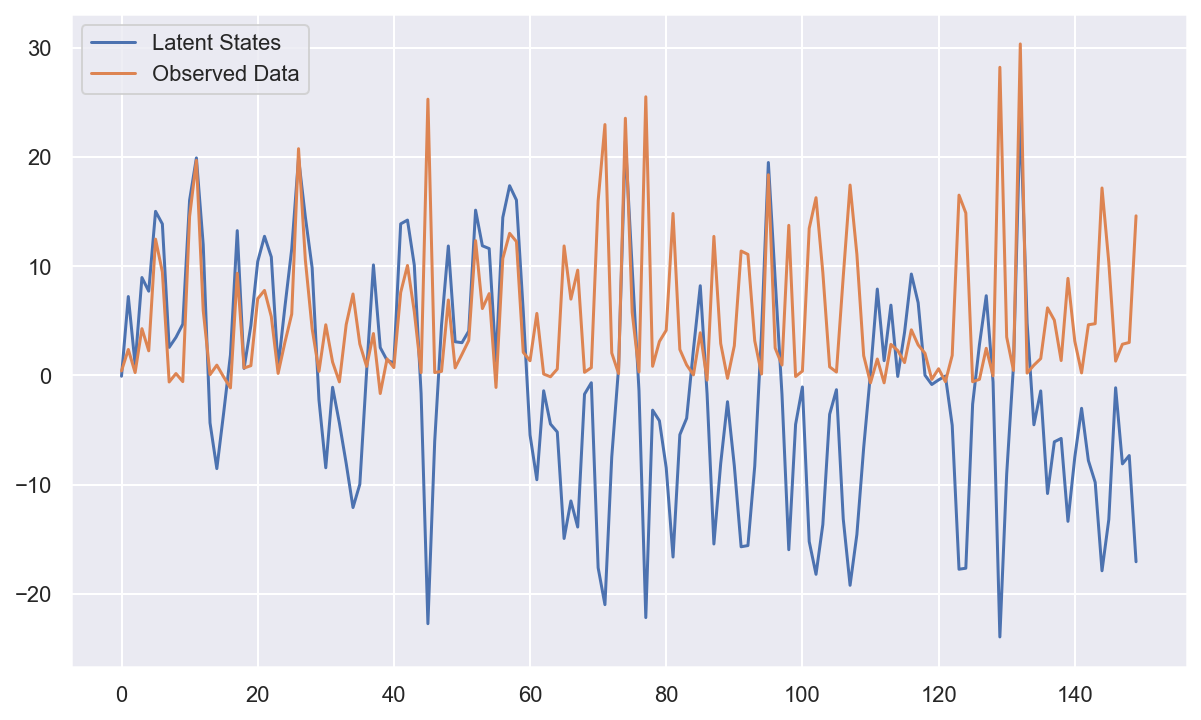

In [3]:
T = 150
x, y = step(T, x_0, marginal = marginal_distribution, transition = transition)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey = True)

sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(x = np.arange(T), y = y, ax = ax, label = "Observed Data")
plt.legend();

RMSE:  87.53441584657052


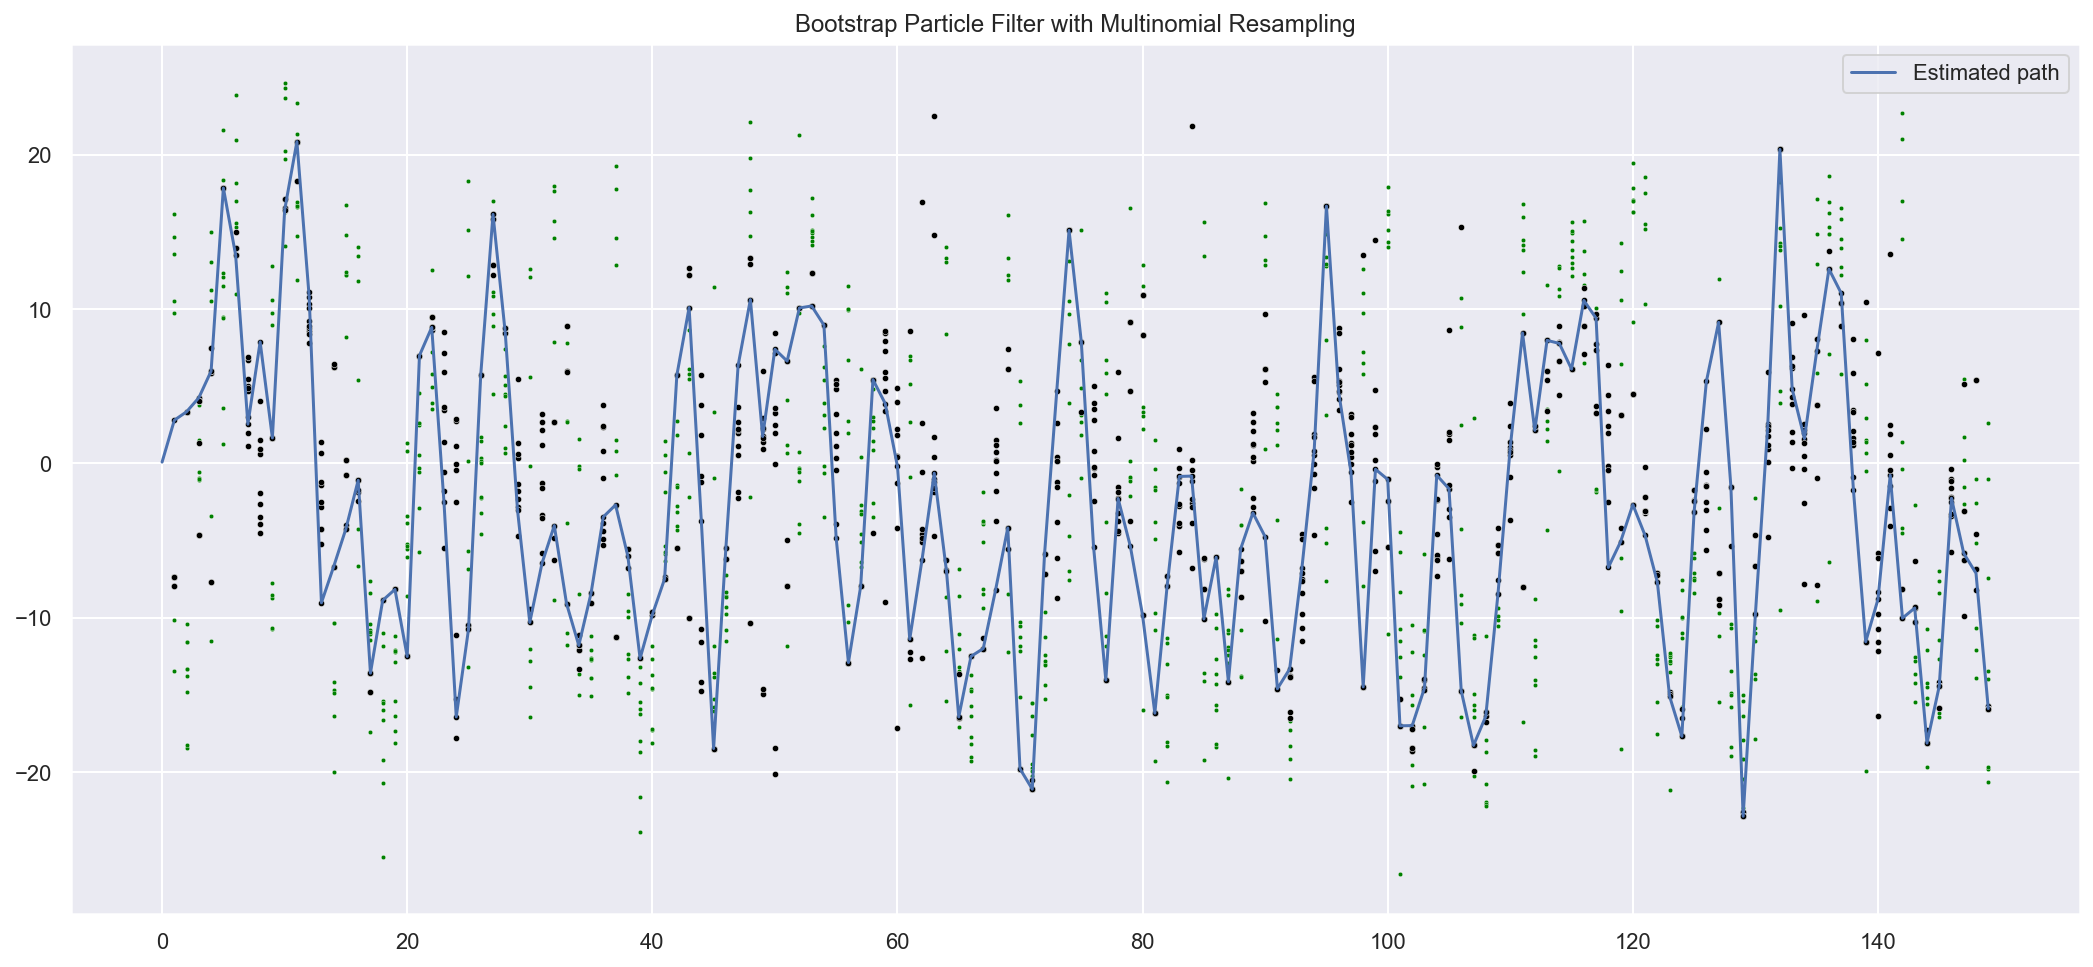

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharey = True)

N = 10 # num particles
particles = np.zeros((N, T)) # memory for N particles at each timestep
weights = np.ones(N) / N # weight for each particle

# initialization: 
particles[:, 0] = norm(0, np.sqrt(10)).rvs(N)

ind = np.arange(N) # indices of rows of particle matrix
for t in range(1, T):
    # 1) Step forward every x_t (sampling step):
    particles[:, t] = transition(particles[:, t-1], t)
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 5, color = "green")
    
    # 2) Evaluate importance weights and normalize: 
    weights = conditional_marginal(y = y[t], x = particles[:, t])
    weights = np.nan_to_num(weights / np.sum(weights), 0)
    
    # 3) Resample with replacement using weights
    # calculate ESS: 
    ess = 1 / sum(weights**2)
    if ess < (N / 2):
        # multinomial resampling:
        resample_ind = np.random.choice(ind, size = N, p = weights)
        particles = particles[resample_ind, :]
        
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 10, color = "black")

print("RMSE: ", rmse(np.apply_along_axis(np.mean, 0, particles), x))
    
# sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(x = np.arange(T), label = "Estimated path",
             y = np.apply_along_axis(np.mean, 0, particles),)\
    .set_title("Bootstrap Particle Filter with Multinomial Resampling")
plt.legend();
plt.show();

The transition density is probabilistic, so every time we generate an X, it is different.

#### Note on Resampling

Multinomial resampling is terrible - **why?**

## Jittering Particles

We can jitter the particles at each resampling step to improve the particle impoverishment problem. 

In [5]:
def systematic_resample(weights):
    """ Performs the systemic resampling algorithm used by particle filters.

    This algorithm separates the sample space into N divisions. A single random
    offset is used to to choose where to sample from for all divisions. This
    guarantees that every sample is exactly 1/N apart.
    
    Taken straight from the source code for filterpy: 
    https://filterpy.readthedocs.io/en/latest/_modules/filterpy/monte_carlo/resampling.html#residual_resample
    """
    N = len(weights)

    # make N subdivisions, and choose positions with a consistent random offset
    positions = (random() + np.arange(N)) / N

    indexes = np.zeros(N, 'i')
    cumulative_sum = np.cumsum(weights)
    i, j = 0, 0
    while i < N:
        if positions[i] < cumulative_sum[j]:
            indexes[i] = j
            i += 1
        else:
            j += 1
    return indexes

RMSE:  61.49812339215973


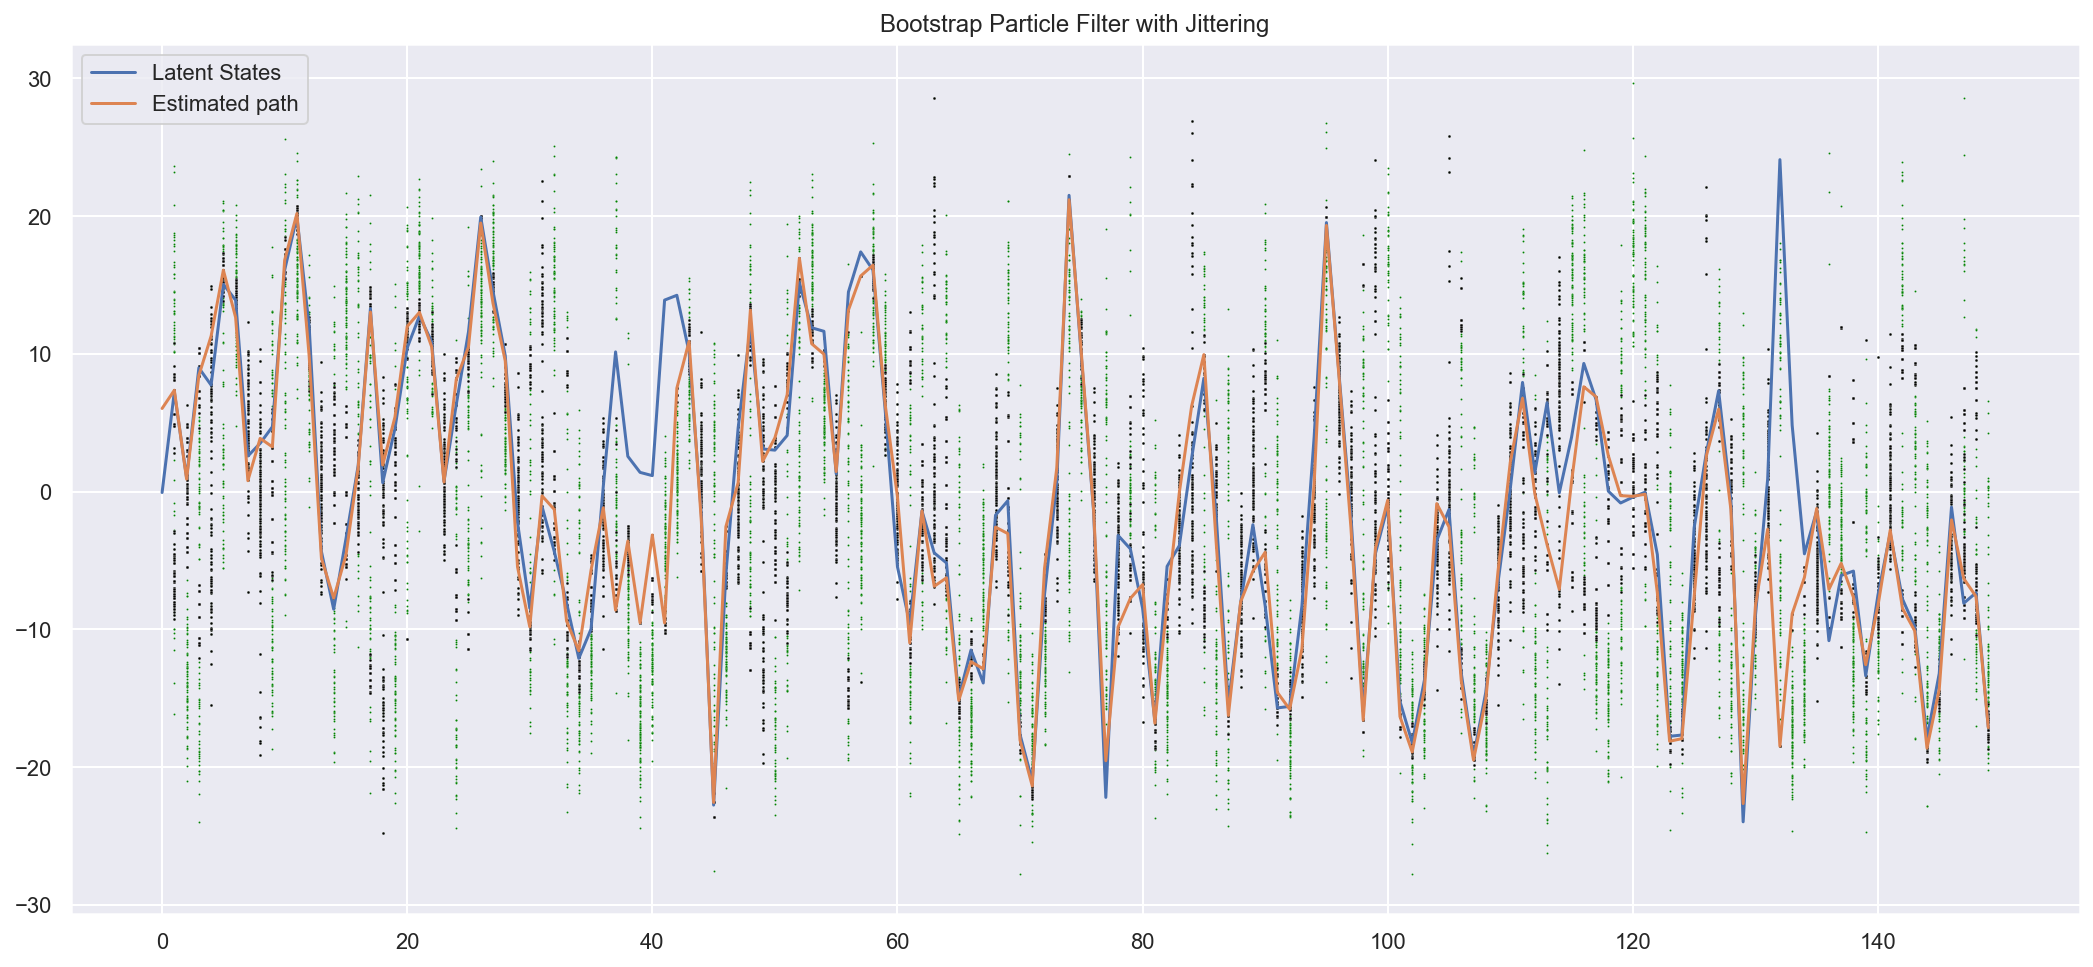

In [65]:
# Particle Filter:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharey = True)

N = 100 # num particles
particles = np.zeros((N, T)) # memory for N particles at each timestep
weights = np.ones(N) / N # weight for each particle

# initialization: 
particles[:, 0] = norm(0, np.sqrt(10)).rvs(N)

ind = np.arange(N) # indices of rows of particle matrix
for t in range(1, T):
    # 1) Step forward every x_t (sampling step):
    particles[:, t] = transition(particles[:, t-1], t)
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 1, color = "green")
    
    # 2) Evaluate importance weights and normalize: 
    weights = conditional_marginal(y = y[t], x = particles[:, t])
    weights = np.nan_to_num(weights / np.sum(weights), 0)
    
    # 3) Resample with replacement using weights
    # calculate ESS: 
    ess = 1 / sum(weights**2)
    if ess < (N / 2):
        # systematic resampling:
        resample_ind = systematic_resample(weights)
        particles = particles[resample_ind, :]
        
    sns.scatterplot(x = t, y = particles[:, t], ax = ax, 
                    s = 2, color = "black")
    # 4: Jitter particles
    jitter = norm(loc = 0, scale = 0.03).rvs(N)
    particles[:, t] += jitter

print("RMSE: ", rmse(np.apply_along_axis(np.mean, 0, particles), x))
    
sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(x = np.arange(T),
             y = np.apply_along_axis(np.mean, 0, particles),
             label = "Estimated path")\
    .set_title("Bootstrap Particle Filter with Jittering")
plt.legend();
plt.show();

## Summarizing Particles with Multivariate Gaussian

We can summarize the particles using different models so that we don't have to carry around empirical estimates of the posterior for the latent variables. Some of the ways this can be done, in increasing order of complexity are: 

* Multivariate Normal: Sample particles from a MVN at each timestep. Update the mean and covariance matrix with a weighted average and variance of the particles sampled

* Mixture of Gaussians: More expressive than the MVN, but how do we make it smooth? (Martin posed this question)

* Gaussian Copula: Martin also mentioned this, but as usual i have no idea what he meant

#### Why is the marginal likelihood calculation a product of a sum and not the sum of a product?

In [algorithm 2](https://arxiv.org/pdf/1306.3277.pdf), the marginal likelihood, $p(y \mid \theta)$ is given as: 

$$ p(y \mid \theta) = \prod_{i = 1}^T \frac{1}{N_{p}} \sum_{j = 1}^{N_{p}} w^j_{t_i} $$

Where $w^j_{t_i}$ is the weight of the $j$-th particle at the $t_i$-th timestep. The question is: why is the marginal likelihood calcualtion a product of this sum and not a sum of the product. 

##### Answer: 

The likelihood function is: 

$$ L(\theta; X, Y) = \prod_{i = 1}^T p(y_t \mid x_t, \theta) $$

Each weight, $w^j_{t_i}$ is an approximation of the pdf $p(y_t \mid x_t, \theta)$. Then $\frac{1}{N_{p}} \sum_{j = 1}^{N_{p}} w^j_{t_i}$ is a Monte Carlo approximation of the likelihood function at timestep $t_i$. We multiply this likelihood estimate at each timestep to get the full likelihood. 

Follow ups: 
* If we switch the sum and product, what does that mean? 
* What impact does the resampling step have on the marginal likelihood calculation? 

RMSE:  65.53097964765034


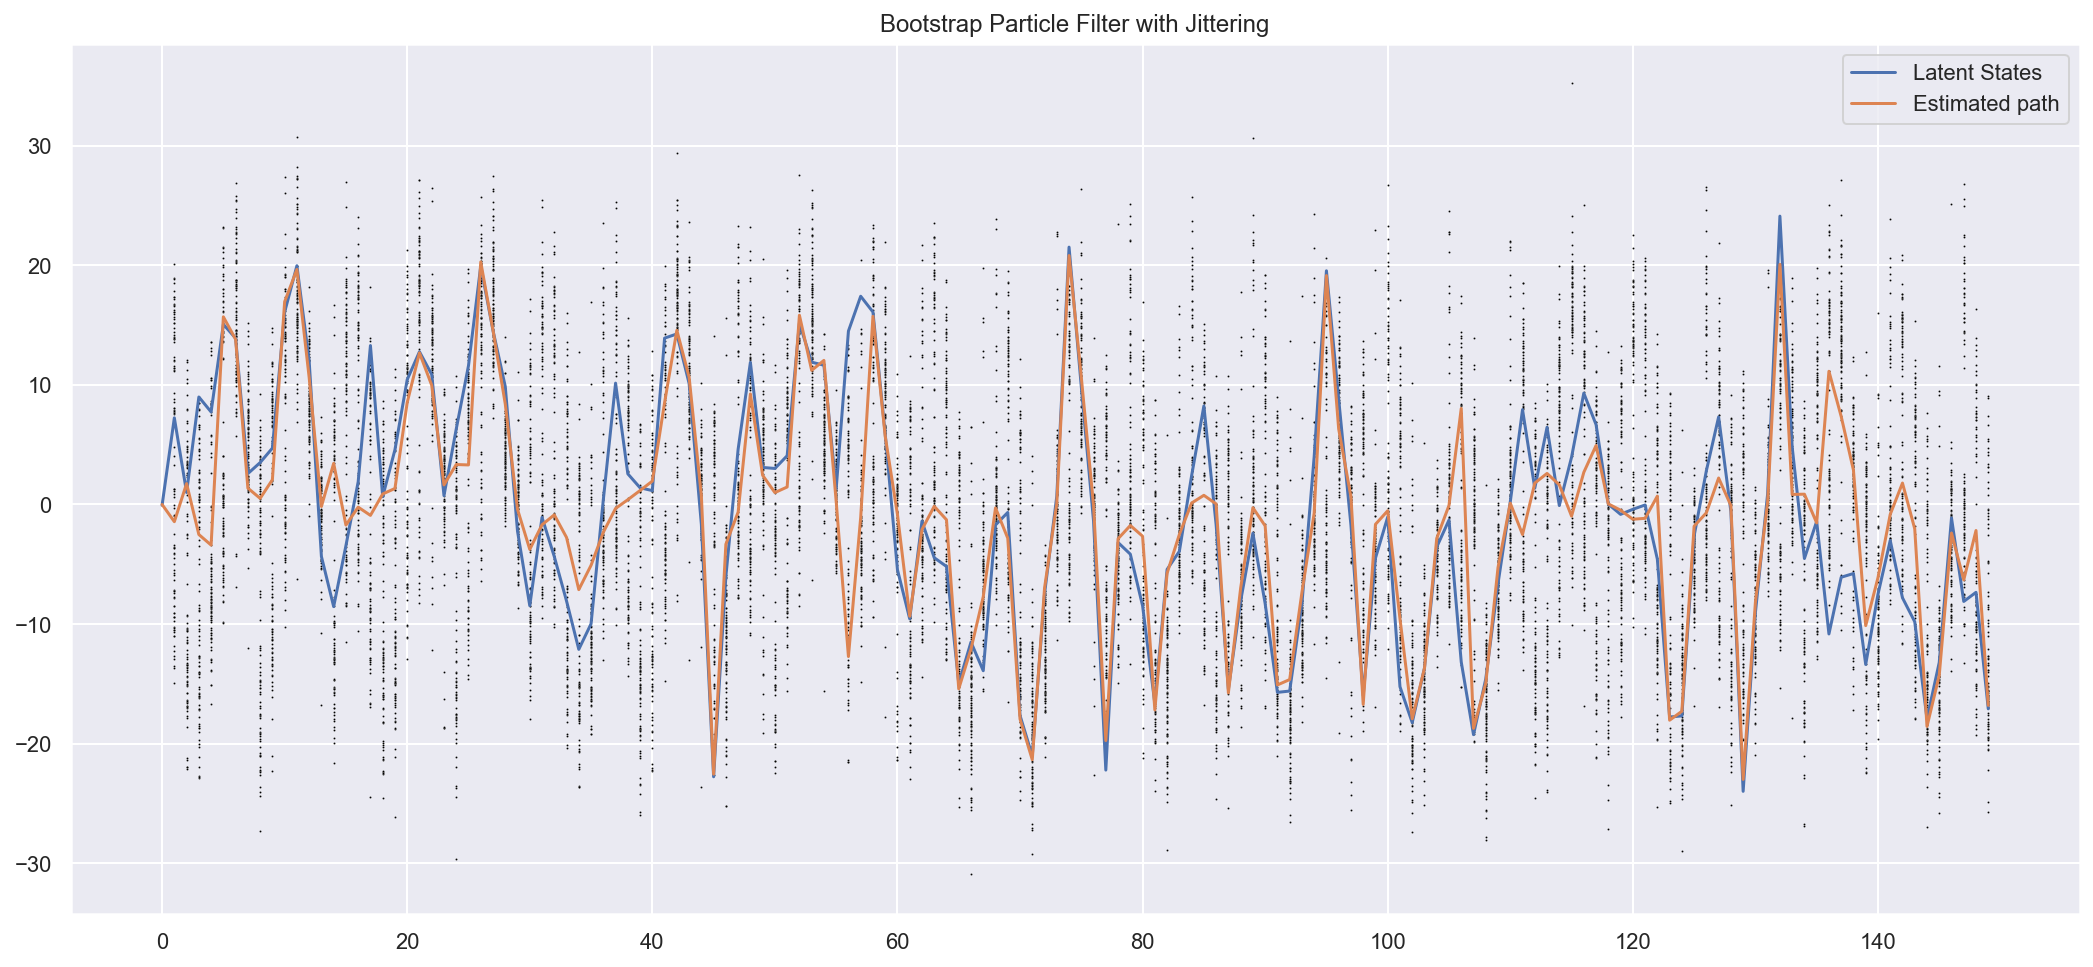

In [62]:
# Particle Filter:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 8), sharey = True)

N = 100 # num particles
mus = np.zeros(T+1) # MVN means
sigma2s = np.ones(T+1) # MVN sigma^2's
weights = np.ones(N) / N # weight for each particle

ind = np.arange(N) # indices of rows of particle matrix
for t in range(1, T):
    # 1) Sample particles
    particles = norm(loc = mus[t], scale = np.sqrt(sigma2s[t])).rvs(N) # X_t-1
    particles = transition(particles, t) # X_t
    sns.scatterplot(x = t, y = particles, ax = ax, 
                    s = 1, color = "black")
    
    # 2) Evaluate importance weights and normalize: 
    weights = conditional_marginal(y = y[t], x = particles)
    weights = np.nan_to_num(weights / np.sum(weights), 0) # normalize weights
    
    # Update particle distribution using weights and previous particles
    mus[t+1] = np.sum(weights * particles) # weigthed average of particles (weights already normalized)
    sigma2s[t+1] = np.cov(particles)

print("RMSE: ", rmse(mus[1:], x))
    
sns.lineplot(x = np.arange(T), y = x, ax = ax, label = "Latent States")
sns.lineplot(x = np.arange(T),
             y = mus[1:],
             label = "Estimated path")\
    .set_title("Bootstrap Particle Filter with Jittering")
plt.legend();
plt.show();

### Gaussian Copula

Now try to summarize the particles with a Gaussian copula.

In order to use GC, we need multivariate latent variables

In [75]:
import warnings
warnings.filterwarnings('ignore')

from copulas.datasets import sample_trivariate_xyz
from copulas.multivariate import GaussianMultivariate
from copulas.visualization import compare_3d

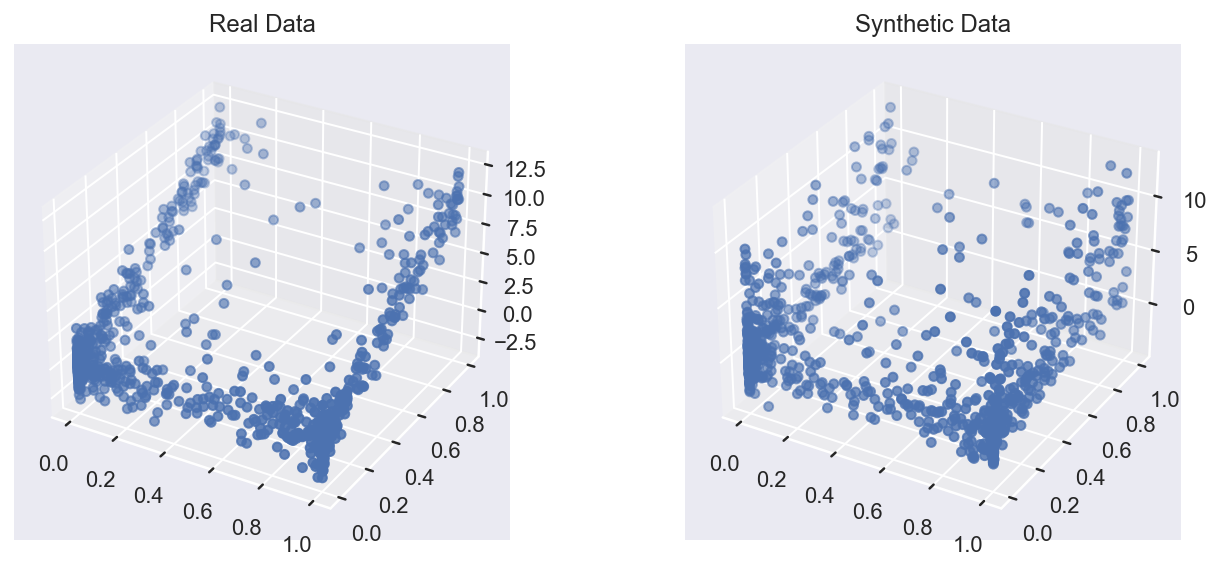

In [76]:
# Load a dataset with 3 columns that are not independent
real_data = sample_trivariate_xyz()

# Fit a gaussian copula to the data
copula = GaussianMultivariate()
copula.fit(real_data)

# Sample synthetic data
synthetic_data = copula.sample(len(real_data))

# Plot the real and the synthetic data to compare
compare_3d(real_data, synthetic_data)

In [77]:
real_data

,x,y,z
0,9.004177e-05,2.883992e-06,0.638689
1,8.819273e-01,2.911979e-07,1.058121
2,5.003865e-01,4.886504e-04,0.372506
3,1.838544e-12,5.392802e-02,0.687370
4,1.627915e-01,1.634269e-08,-0.881068
...,...,...,...
995,7.344071e-05,5.015984e-02,2.697822
996,1.475430e-15,7.183602e-01,7.676588
997,9.956023e-01,7.138870e-09,-0.057518
998,1.000000e+00,1.709259e-05,1.075514


## Unscented Kalman Filter

In [247]:
from numpy.random import randn
import filterpy
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

def fx(x, dt):
    # state transition function - predict next state based
    # on constant velocity model x = vt + x_0
    F = np.array([[1, dt, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, dt],
                  [0, 0, 0, 1]], dtype=float)
    return np.dot(F, x)

def hx(x):
    # measurement function - convert state into a measurement
    # where measurements are [x_pos, y_pos]
    return np.array([x[0], x[2]])

dt = 0.1

In [ ]:
# create sigma points to use in the filter. This is standard for Gaussian processes
points = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=-1)
kf = UnscentedKalmanFilter(dim_x=4, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)
kf.x = np.array([-1., 1., -1., 1]) # initial state
kf.P *= 0.2 # initial uncertainty
z_std = 0.1
kf.R = np.diag([z_std**2, z_std**2]) # 1 standard
kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=0.01**2, block_size=2)
zs = [[i+randn()*z_std, i+randn()*z_std] for i in range(50)] # measurements

for z in zs:
    kf.predict()
    kf.update(z)
    print(kf.x, 'log-likelihood', kf.log_likelihood)

## Stochastic Volatility

Try to follow [this](https://www.cs.ubc.ca/~arnaud/doucet_johansen_tutorialPF.pdf) writeup 



## Jax tests

In [45]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as random

t = jnp.zeros((10, 5, 3), dtype=int)

In [12]:
t = jnp.zeros((10, 5, 3), dtype=int)
t.at[1].add(1)[0]

DeviceArray([[0, 0, 0],
             [0, 0, 0],
             [0, 0, 0],
             [0, 0, 0],
             [0, 0, 0]], dtype=int32)

In [51]:
n_particles = 3
n_states = 4
wgt = jnp.array([0.3, 0.2, 0.5])

particles = jnp.ones((n_particles, n_states))
particles = particles.at[1].set([0, 0.2, 0.1, -1])
particles = particles.at[2].set([-5, 0., 0.-3, 5])
particles

jnp.average(particles, axis = 0, weights = wgt)
jnp.cov(jnp.transpose(particles), aweights = wgt)

DeviceArray([[ 1. ,  1. ,  1. ,  1. ],
             [ 0. ,  0.2,  0.1, -1. ],
             [-5. ,  0. , -3. ,  5. ]], dtype=float32)

DeviceArray([-2.2 ,  0.34, -1.18,  2.6 ], dtype=float32)

DeviceArray([[ 12.83871   ,   1.6903225 ,   8.393548  , -10.451612  ],
             [  1.6903225 ,   0.31032258,   1.1374192 ,  -1.0064516 ],
             [  8.393548  ,   1.1374192 ,   5.4993544 ,  -6.696775  ],
             [-10.451613  ,  -1.0064515 ,  -6.696775  ,  10.064516  ]],            dtype=float32)

In [108]:
def particle_resample_mvn(particles, logw, key):
    """
    Particle resampler based on multivariate Normal distribution

    Args:
        particles: Matrix of size (n_particles, n_states) containing particles at the current timestep
        logw: Vector of `n_particles` unnormalized log-weights
        key: PRNG key

    Returns: 
        Matrix of `n_particles` integers between 0 and `n_particles-1` sampled with replacement with probabili
    """
    n_particles = particles.shape[0]
    n_states = particles.shape[1]
        
    wgt = jnp.exp(logw - jnp.max(logw))
    prob = wgt / jnp.sum(wgt)
    cov_mat = jnp.cov(jnp.transpose(particles), aweights=prob) # variables are the rows in jnp.cov()
    mu = jnp.average(particles, axis=0, weights=prob)

    if n_states == 1:
        # cant use MVNormal, Jax complains
        Z = random.normal(key, shape = (n_particles, ))
        return mu + jnp.sqrt(cov_mat) * Z
    
    return random.multivariate_normal(key, mean = mu,
                                      cov = cov_mat,
                                      shape = (n_particles, ))

def particle_resample(logw, key):
    wgt = jnp.exp(logw - jnp.max(logw))
    prob = wgt / jnp.sum(wgt)
    n_particles = logw.size
    return random.choice(key,
                         a=jnp.arange(n_particles),
                         shape=(n_particles,), p=prob)

key = random.PRNGKey(0)

In [105]:
n_particles = 3
n_states = 2
wgt = jnp.array(np.random.rand(n_particles)) # unnormalized weights
particles = jnp.ones((n_particles, n_states))
particles = particles.at[0].set([0.23, 0.55])
particles = particles.at[1].set([3.2, 1.9])
particles = particles.at[2].set([-12, 0.4])
particles
wgt

particle_resample_mvn(particles, logw = jnp.log(wgt), key = key).shape

DeviceArray([[  0.23,   0.55],
             [  3.2 ,   1.9 ],
             [-12.  ,   0.4 ]], dtype=float32)

DeviceArray([0.7326617 , 0.24138351, 0.55866575], dtype=float32)

(3, 2)

In [111]:
# particle_resample(jnp.log(wgt), key).shape
X_particles = jnp.zeros((n_particles, n_states))
X_particles.shape

(4, 1)

In [107]:
n_particles = 4
n_states = 1
wgt = jnp.array(np.random.rand(n_particles)) # unnormalized weights
particles = jnp.ones((n_particles, n_states))
particles = particles.at[0].set(0.25)
particles = particles.at[1].set(3.2)
particles = particles.at[2].set(-12)
particles
wgt

particle_resample_mvn(particles, logw = jnp.log(wgt), key = key).shape

DeviceArray([[  0.25],
             [  3.2 ],
             [-12.  ],
             [  1.  ]], dtype=float32)

DeviceArray([0.0577877 , 0.17993097, 0.28426775, 0.9157273 ], dtype=float32)

(4,)

In [94]:
X_particles = jnp.zeros((5, n_particles, n_states))
X_particles = X_particles.at[0].set(0.25)

# particle_resample_mvn(X_particles[t-1], logw_particles[t-1], subkey)
# X_particles.at[1].set(particle_resample_mvn(X_particles[0], logw = jnp.log(wgt), key = key))
particle_resample_mvn(X_particles[0], logw = jnp.log(wgt), key = key).shape
X_particles[1].shape

(4,)

(4, 1)